In [1]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import pickle
from DKF_TrainingFunctions import *

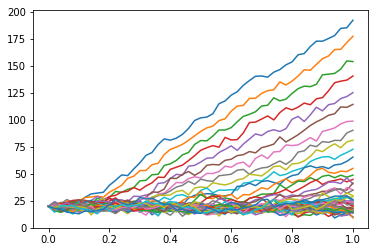

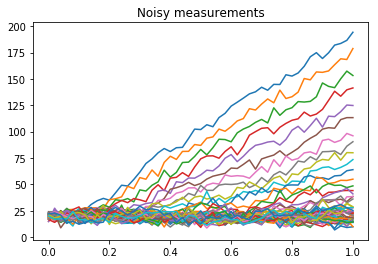

1


In [2]:
# dataset creation:
if 1:
    %run CreateTrainingSet_calore_1d_fd_4DKF.py
#endif

In [3]:
# stima delle temperature interne con il filtro di Kalman:
print("N = ",N)
A = Model['AInit']
nx = A.shape[1]
B = np.zeros((nx,1)); B[0,0] = dt; B = A @ B
C = np.eye(nx); #np.zeros((1,nx)); C[0,0] = 1
ny = C.shape[0]; print("nx = ",nx," , ny = ",ny)
Q = Model['QInit']
R = Model['RInit']
vmean_n2rpe = np.zeros(nx+1); vmean_n2rfe = np.zeros(nx+1)
vmean_NCPpe = np.zeros(nx+1); vmean_NCPfe = np.zeros(nx+1)
for ix in [0]: # "0" non esclude alcuna variabile
#for ix in range(0,nx+1):
    if 1:
        x0 = np.squeeze(TrainingSet[2][0])
    else:
        x0 = np.zeros(nx)
    #endif
    ypred = np.zeros((ny,N+1))
    x = np.atleast_2d(x0.copy()).T
    Xpred_hist = np.zeros((x.shape[0],N+1))
    Xpred_hist[:,0] = x0.copy()
    X_hist = np.zeros((x.shape[0],N+1))
    X_hist[:,0] = x0.copy()
    L_hist = np.zeros((nx,ny,N+1))
    pe = np.zeros((ny,N+1)); n2rpe = np.zeros(N+1)
    fe = np.zeros((ny,N+1)); n2rfe = np.zeros(N+1)
    y_hist = np.zeros((ny,N+1))
    P = Model['PInit']
    x_mask = np.ones((nx,1))
    for i in range(0,N):
        #print("i = ",i)
        x = A @ x + B @ np.atleast_2d(f0(i*dt))
        Xpred_hist[:,i+1] = np.squeeze(x[:,0])
        ypred[:,[i+1]] = C @ x;
        P = A @ P @ A.T + Q
        Lambda = C @ P @ C.T + R
        #print("Lambda.shape = ",Lambda.shape," , C.shape = ",C.shape," , P.shape",P.shape)
        tmp = np.linalg.solve(Lambda.T, C @ P.T); L = tmp.T;  #L = P*C.T*invert(Lambda)
        L_hist[:,:,i+1] = L.copy()
        #print("L = ",L)
        y_meas = C @ TrainingSet[3][0][:,[i+1]]
        pe[:,[i+1]] = y_meas - ypred[:,[i+1]]; n2rpe[i+1] = np.linalg.norm(pe)/np.linalg.norm(y_meas)
        x = x + L@pe[:,[i+1]]
        X_hist[:,i+1] = np.squeeze(x[:,0])
        y_hist[:,[i+1]] = C @ x
        fe[:,[i+1]] = y_meas - y_hist[:,[i+1]]; n2rfe[i+1] = np.linalg.norm(fe)/np.linalg.norm(y_meas)
        #P = P - L*C*P  #P*C.T*inv(Lambda)*C*P
        P = P - P @ C.T @ np.linalg.inv(Lambda) @ C @ P
        #print "P = ",P
        #print "norm(P) = ",np.linalg.norm(P)
    #endfor
    #print("fe.shape = ",fe.shape," , pe.shape = ",pe.shape)
    PeriodogramResidues = ComputePeriodogramResidue(fe, pe)
    #print("PeriodogramResidues.shape = ",PeriodogramResidues.shape)
    if 0:
        plt.figure(); plt.semilogy(n2rpe,'b-'); plt.semilogy(n2rfe,'m-'); plt.show() 
    #endif
    vmean_n2rpe[ix] = np.mean(n2rpe); vmean_n2rfe[ix] = np.mean(n2rfe);
    print("mean(n2rpe) = ",np.mean(n2rpe)," , mean(n2rfe) = ",np.mean(n2rfe))
    vmean_NCPpe[ix] = np.mean(PeriodogramResidues[0:nx]);
    vmean_NCPfe[ix] = np.mean(PeriodogramResidues[nx+1:]);
    if 0:
        plt.figure();
        plt.plot(PeriodogramResidues[0:nx],'m-'); print("mean(PeriodogramResidues[0:nx]) = ",np.mean(PeriodogramResidues[0:nx]))
        plt.plot(PeriodogramResidues[nx+1:],'b-'); print("mean(PeriodogramResidues[nx+1:]) = ",np.mean(PeriodogramResidues[nx+1:]))
        plt.grid(); plt.show()
    #endif
#endfor
print("np.argmin(vmean_n2rpe) = ",np.argmin(vmean_n2rpe[1:nx+1])," , np.argmin(vmean_n2rfe) = ",np.argmin(vmean_n2rfe[1:nx+1]))
print("np.argmin(vmean_NCPpe) = ",np.argmin(vmean_NCPpe[1:nx+1])," , np.argmin(vmean_NCPfe) = ",np.argmin(vmean_NCPfe[1:nx+1]))

N =  50
nx =  51  , ny =  51
mean(n2rpe) =  0.2935758209727402  , mean(n2rfe) =  0.13986869619178185
np.argmin(vmean_n2rpe) =  0  , np.argmin(vmean_n2rfe) =  0
np.argmin(vmean_NCPpe) =  0  , np.argmin(vmean_NCPfe) =  0


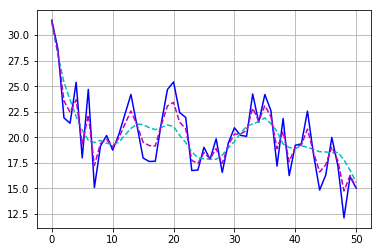

In [4]:
i = 7
plt.figure();
plt.plot(TrainingSet[3][0][:,[i]],'b-')
plt.plot(Xpred_hist[:,[i]],'c--')
plt.plot(X_hist[:,[i]],'m--')
plt.grid()
plt.show()

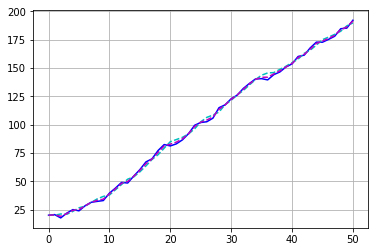

In [5]:
ix = 0
plt.figure();
plt.plot(np.squeeze(TrainingSet[3][0][[ix],:]),'b-')
plt.plot(np.squeeze(Xpred_hist[[ix],:]),'c--')
plt.plot(np.squeeze(X_hist[[ix],:]),'m--')
plt.grid()
plt.show()

In [6]:
#
# DKF
#

In [7]:
from calore_1d_fd import *
n = 50
Dx = 0.1
LinMat = create_fd_matrix(n,Dx).toarray()
print(LinMat.shape)

(51, 51)


In [8]:
TrainingBatchNum = 150 #1000
TrainingBatchSize = 1

# DKF parameters setting:
NetParameters = {}
NetParameters['Experiment'] = sio.loadmat('Experiment.mat',squeeze_me = True)['Experiment']
NetParameters['Layers'] = sio.loadmat(f'LayersExp{NetParameters["Experiment"]}.mat',squeeze_me = True)['Layers']
NetParameters['Model'] = loadPickle(f'ModelExp{NetParameters["Experiment"]}.mat')
NetParameters['C'] = sio.loadmat(f'CExp{NetParameters["Experiment"]}.mat',squeeze_me = True)['C']
NetParameters['StateDimension'] = NetParameters['C'].shape[1]
NetParameters['ObservationDimension'] = NetParameters['C'].shape[0]
NetParameters['WeightMats'] = 'Input'                                                   #Supported values: Input, Identity  
#SERVE? NetParameters['A'], NetParameters['D'], NetParameters['AtA'], NetParameters['B'] = ConstructTVMatrices( NetParameters['Layers'] - NetParameters['ModelDiscoveryFirstState'], NetParameters['Model']['SamplingTimes'] )
NetParameters['WinLen'] = 31
NetParameters['StencilA0'], NetParameters['StencilA1'] = ConstructSGMatrices(NetParameters['WinLen'])
NetParameters['WhitenessDecreaseThreshold'] = -1e-3
NetParameters['L'], NetParameters['LtL'] = ConstructLaplacianMatrices( NetParameters['Layers'], NetParameters['Model']['SamplingTimes'] )
NetParameters['BackPropagation'] = 'Truncated' #'Complete'                                           #Supported values: Complete, Truncated  
NetParameters['ProjectDynamics'] = 'No'
NetParameters['Jacobians'] = 'Approximated'                                             #Supported values: Approximated, Algebraic  
NetParameters['FiniteDifferences'] = 'Central'                                          #Supported values: Forward, Backward, Central  
NetParameters['FiniteDifferencesSkip'] = 1e-9
NetParameters['GainLearningRate'] = (1e-2) / TrainingBatchSize
NetParameters['GainLearningRateReduction'] = 1
NetParameters['GainLearningRateIncrease'] = 1e2
NetParameters['CLearningRate'] = 1e-1
Pen1Val = 1e0
Pen2Val = np.ones(NetParameters['Layers']) * 1e0
NormPen = max(Pen1Val, Pen2Val.max())
NetParameters['Penalty0'] = 1.0
NetParameters['Penalty1'] = np.ones(NetParameters['Layers']) * Pen1Val / NormPen
NetParameters['Penalty2'] = Pen2Val / NormPen
NetParameters['Penalty3'] = 1.e0 / (NetParameters['StateDimension'] * NetParameters['ObservationDimension'])
NetParameters['Penalty4'] = 3.e1
NetParameters['Optimizer'] = 'Adam'
NetParameters['BetaMoment1'] = 0.9
NetParameters['BetaMoment2'] = 0.999
NetParameters['Initialization'] = 'Deterministic'                                       #Supported values: Random, Deterministic, DeterministcComplete  
NetParameters['InitializationMean'] = 0
NetParameters['InitializationSigma'] = 0.0001
NetParameters['AdamEpsilon'] = 1e-16
NetParameters['TrainingConditionStop'] = 'Residues'                                    #Supported values: Whiteness, Residues  
NetParameters['ResidueDecreaseThreshold'] = 1e-3
NetParameters['ActivateCLearning'] = 'No' #'Yes'

# Save net parameters
sio.savemat('DefaultNetParameters.mat', {'NetParameters': NetParameters})


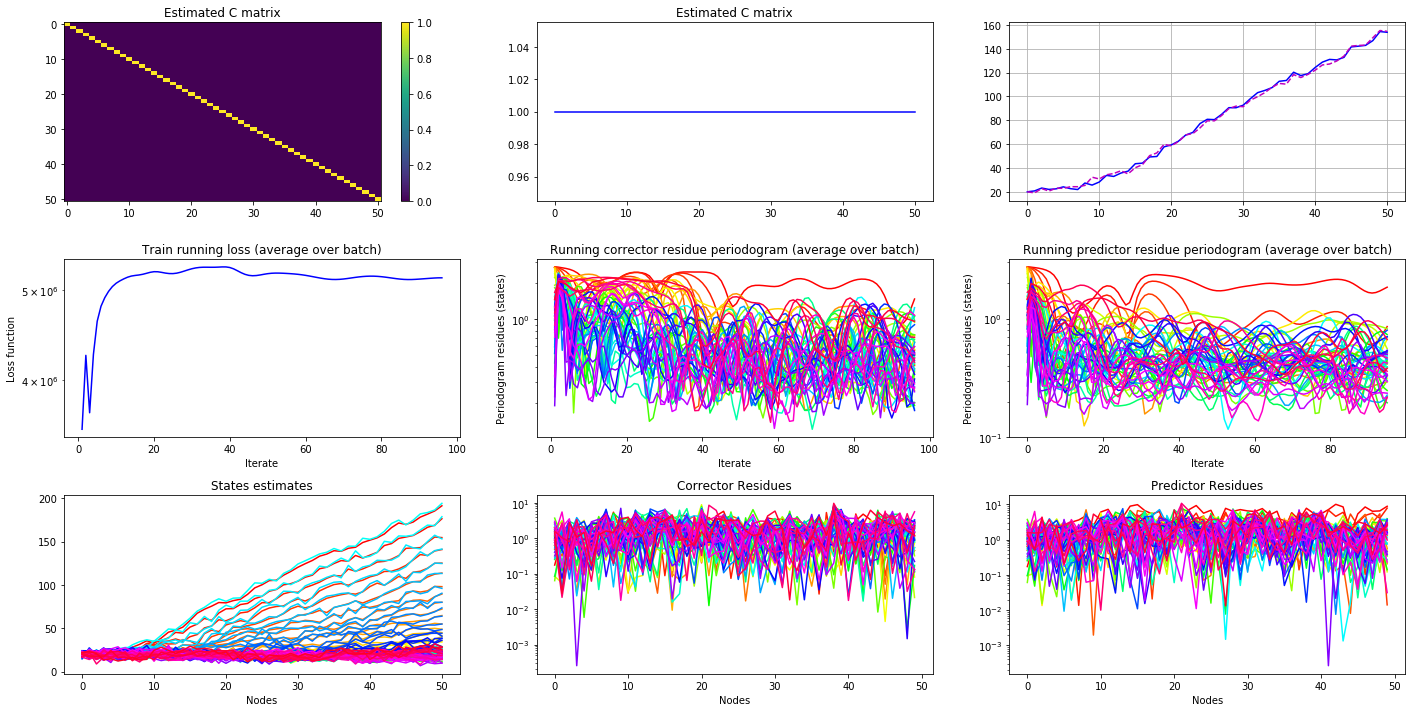

In [ ]:
#### Training:
def decode():
    return 1 # stub
#
# initialize network weights:
NetWeights = InitializeWeights(NetParameters)
# Load the training set
WorkingTrainingSetName = f'LatestTrainingSetExp{NetParameters["Experiment"]}.mat'
TrainingSet = loadPickle(WorkingTrainingSetName)
# Setup dimensions
TrainInstancesNum = np.shape(TrainingSet[0])[0]
TrainingResidues = np.zeros((TrainingBatchNum,1))
PeriodogramResidues = np.zeros((TrainingBatchNum, 2 * NetParameters['ObservationDimension'], TrainInstancesNum))
# Set up the figure
plt.figure(1)
plt.gcf().set_size_inches(20, 10)
# Initialize the moments
Moment1, Moment2 = InitializeGradsAndMoments(NetWeights, NetParameters)[1:]
AdamInd = 1
# Compute weight matrices
MeasurementWeightMats, PredictorWeightMats, MeasurementWeightMatsSym, PredictorWeightMatsSym = ComputeWeightMats(NetParameters)

# Cycle over batch number
for TrainingBatchInd in range(1, TrainingBatchNum+1):
    # Reset gradients for new batch but keep the moments intact
    Grads = InitializeGradsAndMoments(NetWeights, NetParameters)[0]

    # Cycle over each training instance in the batch
    for BatchInd in range(1, TrainingBatchSize+1):
        # Randomly select a training instance
        TrainInstanceInd = BatchInd-1

        # Extract instance
        Inputs = TrainingSet[0][TrainInstanceInd]
        Measurements = TrainingSet[1][TrainInstanceInd]
        FirstState = TrainingSet[2][TrainInstanceInd]
        TrajectoryTrue = TrainingSet[3][TrainInstanceInd]
        StateTrue = TrainingSet[4][TrainInstanceInd]
        Dynamic = TrainingSet[5][TrainInstanceInd]
        
        # parsimony:
        tmpI = np.where(np.diag(NetWeights[-2]) <= 0.0)[0]
        Measurements[tmpI,:] = 0.0
        
        # Print progress
        #OverallProgress = f'Training batch number: {TrainingBatchInd}/{TrainingBatchNum}. \nCurrently processing batch instance: {BatchInd}/{TrainingBatchSize}. \n'
        #print(OverallProgress, end='')

        #PropagationProgress = 'Propagating instance...\n'
        #print(PropagationProgress, end='')

        # Propagate input
        States, MeasurementMinusCStates, GainMeasurementMinusCFs, MeasurementMinusCFs, FStateDynInputs = PropagateInput(Inputs, Measurements, FirstState, Dynamic, F, NetWeights, NetParameters, decode)
        # Assemble gains tensor
        TensorizedGains = ConstructTensorizedGains(NetWeights, NetParameters)

        # Update training residue, cumulative periodograms residues and assemble states evolution
        ShowStates = np.zeros((NetParameters['Layers']+1, NetParameters['StateDimension']))
        ShowCorrectorResidues = np.zeros((NetParameters['Layers'], NetParameters['ObservationDimension']))
        ShowPredictorResidues = np.zeros((NetParameters['Layers'], NetParameters['ObservationDimension']))
        ShowMeasurements = np.zeros((NetParameters['Layers']+1, NetParameters['ObservationDimension']))  # TO BE REMOVED
        ShowStates[0:1,:] = FirstState.T
        ShowMeasurements[0:1,:] = Measurements[:,0:1].T

        for Layer in range(1, NetParameters['Layers'] + 1):
            TrainingResidues[TrainingBatchInd-1,0] += np.squeeze( (NetParameters['Penalty1'][Layer-1]/2)*( MeasurementMinusCStates[:,[Layer-1]].T )@MeasurementWeightMats[Layer-1]@( MeasurementMinusCStates[:,[Layer-1]] )/TrainingBatchSize + (NetParameters['Penalty2'][Layer-1]/2)*( GainMeasurementMinusCFs[:,[Layer-1]].T )@PredictorWeightMats[Layer-1]@( GainMeasurementMinusCFs[:,[Layer-1]] )/TrainingBatchSize )
            ShowStates[Layer,:] = States[:,[Layer]].T
            ShowMeasurements[Layer,:] = Measurements[:,Layer:Layer+1].T  # TO BE REMOVED
            ShowCorrectorResidues[Layer-1,:] = MeasurementMinusCStates[:,[Layer-1]].T
            ShowPredictorResidues[Layer-1,:] = GainMeasurementMinusCFs[:,[Layer-1]].T
        #endfor
        TrainingResidues[TrainingBatchInd-1] += np.squeeze( (NetParameters['Penalty0']/2)*np.linalg.norm( States[:,-1] - StateTrue )**2/TrainingBatchSize + (NetParameters['Penalty3']/2)*np.linalg.norm( np.tensordot(TensorizedGains, NetParameters['L'], axes=([2], [1])) )**2/TrainingBatchSize )
        PeriodogramResidues[TrainingBatchInd-1,:,TrainInstanceInd-1] += ComputePeriodogramResidue(MeasurementMinusCStates, MeasurementMinusCFs)

        # Check whiteness
        #if ( (NetParameters['ActivateWhitenessMask'] == 'Yes') and (not InhibitWhitenessCheck) and (TrainingBatchInd > NetParameters['WhitenessIterationCheck'] and AdamInd > NetParameters['WhitenessUpdateCheck']) ):
        #    StopCond = (PeriodogramResidues[TrainingBatchInd-1,NetParameters['ObservationDimension']:,TrainInstanceInd-1] - PeriodogramResidues[TrainingBatchInd-2,NetParameters['ObservationDimension']:,TrainInstanceInd-1] < NetParameters['WhitenessDecreaseThreshold']).T
        ##endif

        #BackPropagationProgress = 'Back-propagating instance...\n'
        #print(BackPropagationProgress, end='')

        # Compute jacobians
        StateJacobians, DynJacobians = ComputeJacobians(F, States, None, Inputs, None, None, FStateDynInputs, NetParameters)

        # Backpropagate output
        Grads = BackPropagateOutput(StateTrue, Dynamic, States, MeasurementMinusCStates, GainMeasurementMinusCFs, MeasurementMinusCFs, FStateDynInputs, TensorizedGains, MeasurementWeightMatsSym, PredictorWeightMatsSym, Grads, StateJacobians, DynJacobians, NetWeights, NetParameters)
    #endfor

    #UpdateWeightsProgress = 'Updating weights...\n'
    #print(UpdateWeightsProgress, end='')

    # Update net weights
    #ERA COSì: NetWeights, Moment1, Moment2 = UpdateWeights(NetWeights, copy.deepcopy(Grads), Moment1, Moment2, Dynamic, AdamInd, np.ones((NetParameters['StateDimension'], 1)) - NetParameters['C'].T@( np.logical_not(np.sum(LaggedGainMask, axis=1))*1 ), NetParameters)
    NetWeights, Moment1, Moment2 = UpdateWeights(NetWeights, copy.deepcopy(Grads), Moment1, Moment2, Dynamic, AdamInd, np.ones((NetParameters['StateDimension'], 1)), NetParameters)

    AdamInd += 1

    #print('\b' * len(UpdateWeightsProgress), end='')

    # Adaptively change the learning rates
    if TrainingResidues[TrainingBatchInd-1] < NetParameters['GainLearningRate']:
        NetParameters['GainLearningRate'] *= NetParameters['GainLearningRateReduction']
    #endif
    #if ( (NetParameters['TrainingConditionStop'] == 'Residues') and InhibitWhitenessCheck and (AdamInd > NetParameters['WhitenessUpdateCheck']) and ( (TrainingResidues[TrainingBatchInd-2] - TrainingResidues[TrainingBatchInd-1] < NetParameters['ResidueDecreaseThreshold']) and (TrainingResidues[TrainingBatchInd-2] - TrainingResidues[TrainingBatchInd-1] > 0) ) ):
    #    # Early stop training condition based on residues decrease
    #    StopTraining = 1

    # Show training output
    clear_output(wait=True)
    plt.figure(1, figsize=(20, 10))
    plt.clf()

    plt.subplot(3, 3, 1)
    #plt.plot(StateTrue, 'b+-')
    #plt.plot(States[-1], 'm.-')
    #plt.title('Output state comparison')
    #plt.xlabel('Nodes')
    #plt.legend(['True','Estimated'],loc='upper right')
    plt.imshow(NetWeights[-2], aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title('Estimated C matrix')

    plt.subplot(3, 3, 2)
    plt.plot(np.diag(NetWeights[-2]),'b-')
    plt.title('Estimated C matrix')
    
    ix = 2
    plt.subplot(3, 3, 3)
    plt.plot(np.squeeze(TrainingSet[3][0][[ix],:]),'b-')
    #plt.plot(np.squeeze(Xpred_hist[[ix],:]),'c--')
    plt.plot(np.squeeze(States[[ix],:].T),'m--')
    plt.grid()
    #plt.subplot(3, 3, 3)
    #plt.imshow(NetWeights[-1][-1], aspect='auto', cmap='viridis')
    #plt.colorbar()
    #plt.title('Reconstructed unmodeled dynamics')

    plt.subplot(3, 3, 4)
    plt.semilogy(range(1, TrainingBatchInd + 1), TrainingResidues[:TrainingBatchInd], 'b-')
    plt.title('Train running loss (average over batch)')
    plt.xlabel('Iterate')
    plt.ylabel('Loss function')

    plt.subplot(3, 3, 5)
    plt.gca().set_prop_cycle(color=plt.cm.hsv(np.linspace(0, 1, NetParameters['ObservationDimension']+1)))
    plt.semilogy(range(1, TrainingBatchInd + 1), PeriodogramResidues[:TrainingBatchInd, :NetParameters['ObservationDimension'],0])
    #plt.legend([f'ObservedState:{i+1}' for i in range(NetParameters['ObservationDimension'])], loc='lower left')
    plt.title('Running corrector residue periodogram (average over batch)')
    plt.xlabel('Iterate')
    plt.ylabel('Periodogram residues (states)')

    plt.subplot(3, 3, 6)
    plt.gca().set_prop_cycle(color=plt.cm.hsv(np.linspace(0, 1, NetParameters['ObservationDimension']+1)))
    plt.semilogy(PeriodogramResidues[:TrainingBatchInd, NetParameters['ObservationDimension']:,0])
    #plt.legend([f'ObservedState:{i+1}' for i in range(NetParameters['ObservationDimension'])], loc='lower left')
    plt.title('Running predictor residue periodogram (average over batch)')
    plt.xlabel('Iterate')
    plt.ylabel('Periodogram residues (states)')

    plt.subplot(3, 3, 7)
    plt.gca().set_prop_cycle(color=plt.cm.hsv(np.linspace(0, 1, 2 * NetParameters['StateDimension']+1)))
    plt.plot(np.hstack((ShowStates @ NetParameters['C'].T, ShowMeasurements)))
    #plt.legend([f'EstimatedState:{i+1}' for i in range(NetParameters['ObservationDimension'])] * 2, loc='upper left')
    plt.title('States estimates')
    plt.xlabel('Nodes')

    plt.subplot(3, 3, 8)
    plt.gca().set_prop_cycle(color=plt.cm.hsv(np.linspace(0, 1, NetParameters['StateDimension']+1)))
    plt.semilogy(np.abs(ShowCorrectorResidues))
    #plt.legend([f'CorrectorResidues:{i+1}' for i in range(NetParameters['ObservationDimension'])], loc='upper left')
    plt.title('Corrector Residues')
    plt.xlabel('Nodes')

    plt.subplot(3, 3, 9)
    plt.gca().set_prop_cycle(color=plt.cm.hsv(np.linspace(0, 1, NetParameters['StateDimension']+1)))
    plt.semilogy(np.abs(ShowPredictorResidues))
    #plt.legend([f'PredictorResidues:{i+1}' for i in range(NetParameters['ObservationDimension'])], loc='upper left')
    plt.title('Predictor Residues')
    plt.xlabel('Nodes')

    plt.tight_layout()
    plt.draw(); plt.show()
    plt.pause(0.1)
#endfor
print('********************************************************************************')
print('Training completed.')
print('Updated weights for the net have been saved and are ready to be used.')
print('********************************************************************************\n')
